In [7]:
import matplotlib.pyplot as plt
import glob
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix

file_main_path = "C:/Users/User/Desktop/碩一/醫學電資專題/醫資專題三/" # Please change this path with your current setting!!!

# LOAD DATASET

In [2]:
# 01_TUMOR
file_sub_path = "Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/01_TUMOR/"
path = file_main_path + file_sub_path
tumor_image = []
for filename in glob.glob(os.path.join(path, '*.tif')):
    tumor_image.append(plt.imread(filename))
tumor_image = np.asarray(tumor_image)
tumor_index = np.full(len(tumor_image), 0, dtype = int)

In [3]:
# 02_STROMA
file_sub_path = "Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/02_STROMA/"
path = file_main_path + file_sub_path
stoma_image = []
for filename in glob.glob(os.path.join(path, '*.tif')):
    stoma_image.append(plt.imread(filename))
stoma_image = np.asarray(stoma_image)
stoma_index = np.full(len(stoma_image), 1, dtype = int)

In [4]:
# 03_COMPLEX
file_sub_path = "Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/03_COMPLEX/"
path = file_main_path + file_sub_path
complex_image = []
for filename in glob.glob(os.path.join(path, '*.tif')):
    complex_image.append(plt.imread(filename))
complex_image = np.asarray(complex_image)
complex_index = np.full(len(complex_image), 2, dtype = int)

In [5]:
# 04_LYMPHO
file_sub_path = "Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/04_LYMPHO/"
path = file_main_path + file_sub_path
lympho_image = []
for filename in glob.glob(os.path.join(path, '*.tif')):
    lympho_image.append(plt.imread(filename))
lympho_image = np.asarray(lympho_image)
lympho_index = np.full(len(lympho_image), 3, dtype = int)

In [6]:
# 05_DEBRIS
file_sub_path = "Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/05_DEBRIS/"
path = file_main_path + file_sub_path
debris_image = []
for filename in glob.glob(os.path.join(path, '*.tif')):
    debris_image.append(plt.imread(filename))
debris_image = np.asarray(debris_image)
debris_index = np.full(len(debris_image), 4, dtype = int)

In [7]:
# 06_MUCOSA
file_sub_path = "Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/06_MUCOSA/"
path = file_main_path + file_sub_path
mucosa_image = []
for filename in glob.glob(os.path.join(path, '*.tif')):
    mucosa_image.append(plt.imread(filename))
mucosa_image = np.asarray(mucosa_image)
mucosa_index = np.full(len(mucosa_image), 5, dtype = int)

In [8]:
# 07_ADIPOSE
file_sub_path = "Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/07_ADIPOSE/"
path = file_main_path + file_sub_path
adipose_image = []
for filename in glob.glob(os.path.join(path, '*.tif')):
    adipose_image.append(plt.imread(filename))
adipose_image = np.asarray(adipose_image)
adipose_index = np.full(len(adipose_image), 6, dtype = int)

In [9]:
# 08_EMPTY
file_sub_path = "Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/08_EMPTY/"
path = file_main_path + file_sub_path
empty_image = []
for filename in glob.glob(os.path.join(path, '*.tif')):
    empty_image.append(plt.imread(filename))
empty_image = np.asarray(empty_image)
empty_index = np.full(len(empty_image), 7, dtype = int)

In [10]:
# combine all the loaded data
images = np.vstack((tumor_image, stoma_image, complex_image, lympho_image, debris_image, mucosa_image, adipose_image, empty_image))
index = np.concatenate((tumor_index, stoma_index, complex_index, lympho_index, debris_index, mucosa_index, adipose_index, empty_index))

In [11]:
# 3 DIMENSION
images = np.moveaxis(images, -1, 1) # move axis to pytorch accepted type
print(images.shape)
print(index.shape)

(5000, 3, 150, 150)
(5000,)


In [11]:
def scale(X, x_min, x_max):
    imgs, rgb, d_x, d_y = X.shape[0], X.shape[1], X.shape[2], X.shape[3]
    if rgb != 3:
        print("Input shape of image error, please input images with dimensions: images*rgb*x*y")
    else:
        images_reshape = X.reshape(imgs, rgb, (d_x * d_y))
        X_min = images_reshape.min(axis=2)
        X_min_expand_axis = np.repeat(X_min[:,:,np.newaxis], (d_x * d_y), axis = 2)
        X_max = images_reshape.max(axis=2)
        X_max_expand_axis = np.repeat(X_max[:,:,np.newaxis], (d_x * d_y), axis = 2)
        X_range = X_max_expand_axis - X_min_expand_axis
        image_normal = (x_max-x_min)/X_range * (images_reshape - X_min_expand_axis) + (x_min)
        image_normal_reshape = image_normal.reshape(imgs, rgb, d_x, d_y)
        return image_normal_reshape

# ResNet 34

In [2]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=8):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(3, stride=1)
        self.fc = nn.Linear(512 * 9 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet34(**kwargs):
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    return model

In [18]:
import torch
EPOCH = 50
BATCH_SIZE = 50
LR = 0.001
resnet = resnet34(pretrained = False)
print(resnet)
optimizer = torch.optim.Adam(resnet.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet.cuda()

In [19]:
# Shuffle data set
idx = np.random.permutation(len(images))
x, y = images[idx], index[idx]
x = scale(x, -1, 1)

In [14]:
# Split data to training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
y_train = np.expand_dims(y_train,axis = 1)
y_test = np.expand_dims(y_test,axis = 1)

# Change dtype to tensor and float format
X_train_torch = torch.from_numpy(X_train)
X_test_torch = torch.from_numpy(X_test)
y_train_torch = torch.from_numpy(y_train)
y_test_torch = torch.from_numpy(y_test)

X_train_torch = X_train_torch.float()
y_train_torch = y_train_torch.long()
X_test_torch = X_test_torch.float()
y_test_torch = y_test_torch.long()

# save test torch
torch.save(X_test_torch, 'X_test_torch.pt')
torch.save(y_test_torch, 'y_test_torch.pt')

In [22]:
from torch.autograd import Variable
# start training
loss_list = []
for epoch in range(EPOCH):
    step_length = len(range(0, X_train_torch.size(0), BATCH_SIZE))
    print("epoch: ", str(epoch+1))
    
    losses = []
    for step, beg_i in enumerate(range(0, X_train_torch.size(0), BATCH_SIZE)):
        
        processing = str(round(((step)/ step_length * 100),2)) + "% " +"\r"
        sys.stdout.write(processing)
        sys.stdout.flush()
        
        x_batch = X_train_torch[beg_i:beg_i + BATCH_SIZE, :].cuda()
        y_batch = y_train_torch[beg_i:beg_i + BATCH_SIZE, :].cuda()
        
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)

        output = resnet(x_batch)              # cnn output
        loss = loss_func(output, y_batch.squeeze())   # cross entropy loss
        losses.append(float(loss.cpu().data.numpy()))
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
    loss_list.append(sum(losses))

epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50


In [23]:
resnet = resnet.cpu()
torch.save(resnet.state_dict(), "HISTO_MODEL_RESNET34_ver9_rescale.pkl")

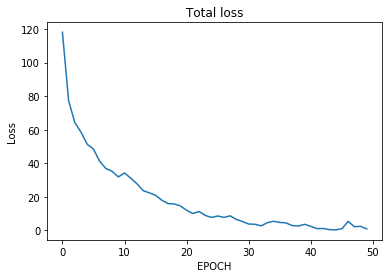

In [25]:
# Loss changing during training
plt.plot(range(0,EPOCH), loss_list)
plt.xlabel("EPOCH")
plt.ylabel("Loss")
plt.title("Total loss")
plt.show()

# Re-load model for prediction

In [15]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=8):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(3, stride=1)
        self.fc = nn.Linear(512 * 9 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def resnet34(**kwargs):
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    return model


In [16]:
X_test_torch = torch.load('X_test_torch.pt')
y_test_torch = torch.load('y_test_torch.pt')

resnet = resnet34(pretrained = False)
resnet.load_state_dict(torch.load("HISTO_MODEL_RESNET34_ver9_rescale.pkl"))

<All keys matched successfully>

In [28]:
# predict by part
part = 20
accuracy_sum = 0 
prediction_list = []
for i in range(part):
    print("finish ", (i+1), " / ", part)
    start = int(i / part * len(X_test_torch))
    end = int((i+1) / part * len(X_test_torch))
    X_test_torch_part = X_test_torch[start:end]
    y_test_torch_part = y_test_torch[start:end]
    
    test_output = resnet(X_test_torch_part)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    prediction_list.append(pred_y.numpy())
    accuracy = sum(pred_y == y_test_torch_part.squeeze()).item()
    accuracy_sum += accuracy
print("accuracy: ", accuracy_sum/len(X_test_torch))

finish  1  /  20
finish  2  /  20
finish  3  /  20
finish  4  /  20
finish  5  /  20
finish  6  /  20
finish  7  /  20
finish  8  /  20
finish  9  /  20
finish  10  /  20
finish  11  /  20
finish  12  /  20
finish  13  /  20
finish  14  /  20
finish  15  /  20
finish  16  /  20
finish  17  /  20
finish  18  /  20
finish  19  /  20
finish  20  /  20
accuracy:  0.9536


In [47]:
prediction_list_numpy = np.array([num for elem in prediction_list for num in elem])
y_test_numpy = np.asarray(y_test_torch).flatten()

In [50]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(prediction_list_numpy, y_test_numpy)
confusion

array([[138,   1,   3,   0,   0,   2,   0,   0],
       [  0, 150,   6,   0,   8,   0,   0,   0],
       [  7,   7, 136,   6,   1,   1,   0,   0],
       [  1,   0,   0, 142,   0,   0,   0,   0],
       [  0,   5,   0,   0, 148,   0,   0,   0],
       [  2,   1,   2,   0,   0, 154,   0,   0],
       [  0,   0,   0,   0,   2,   0, 168,   1],
       [  0,   0,   0,   0,   0,   0,   2, 156]], dtype=int64)

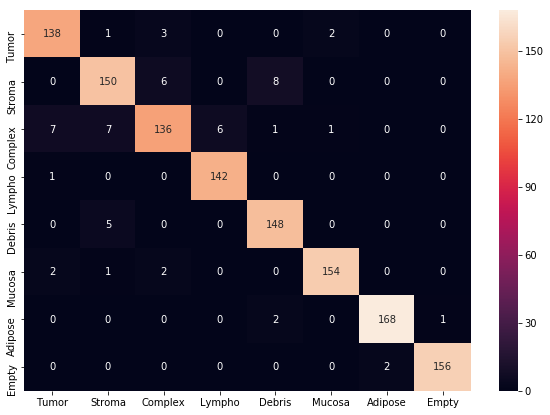

In [56]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
label_list = ["Tumor", "Stroma", "Complex", "Lympho","Debris", "Mucosa","Adipose", "Empty"]
df_cm = pd.DataFrame(confusion, index = [i for i in label_list],
                  columns = [i for i in label_list])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt='g')
plt.show()

# 4 fold validation

In [19]:
# Shuffle data set
idx = np.random.permutation(len(images))
x, y = images[idx], index[idx]
x = scale(x, -1, 1)

In [20]:
def weight_init(m):
    if isinstance(m, nn.Linear): 
        m.reset_parameters()

In [21]:
kfold_counter = 1
kf = KFold(n_splits=4, random_state = 42, shuffle=True)

loss_list_four_fold = []
prediction_list_numpy_four_fold = []
y_test_numpy_four_fold = []
accuracy_rate_four_fold = []
confusion_four_fold = []

for train_index, test_index in kf.split(x):
    print("Strat tenfold: ",kfold_counter)
    
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    y_train = np.expand_dims(y_train,axis = 1)
    y_test = np.expand_dims(y_test,axis = 1)
    
    # Change dtype to tensor and float format
    X_train_torch = torch.from_numpy(X_train)
    X_test_torch = torch.from_numpy(X_test)
    y_train_torch = torch.from_numpy(y_train)
    y_test_torch = torch.from_numpy(y_test)

    X_train_torch = X_train_torch.float()
    y_train_torch = y_train_torch.long()
    X_test_torch = X_test_torch.float()
    y_test_torch = y_test_torch.long()

    # save test torch
    X_test_save_name = "X_test_torch_val" + str(kfold_counter) + ".pt"
    y_test_save_name = "y_test_torch_val" + str(kfold_counter) + ".pt"
    torch.save(X_test_torch, X_test_save_name)
    torch.save(y_test_torch, y_test_save_name)

    kfold_counter += 1
    
    #gpu
    resnet = resnet34(pretrained = False).cuda()
    optimizer = torch.optim.Adam(resnet.parameters(), lr=LR)   # optimize all cnn parameters
    
    # start training
    loss_list = []
    for epoch in range(EPOCH):
        step_length = len(range(0, X_train_torch.size(0), BATCH_SIZE))
        print("epoch: ", str(epoch+1))

        losses = []
        for step, beg_i in enumerate(range(0, X_train_torch.size(0), BATCH_SIZE)):

            processing = str(round(((step)/ step_length * 100),2)) + "% " +"\r"
            sys.stdout.write(processing)
            sys.stdout.flush()

            x_batch = X_train_torch[beg_i:beg_i + BATCH_SIZE, :].cuda()
            y_batch = y_train_torch[beg_i:beg_i + BATCH_SIZE, :].cuda()

            x_batch = Variable(x_batch)
            y_batch = Variable(y_batch)

            output = resnet(x_batch)              
            loss = loss_func(output, y_batch.squeeze())   # cross entropy loss
            losses.append(float(loss.cpu().data.numpy()))
            optimizer.zero_grad()           # clear gradients for this training step
            loss.backward()                 # backpropagation, compute gradients
            optimizer.step()                # apply gradients
        loss_list.append(sum(losses))    
    loss_list_four_fold.append(loss_list)
    
    #back to cpu
    resnet.cpu()
    
    #save model
    resnet_name = "HISTO_MODEL_RESNET34_ver12_rescale_four_fold" + str(kfold_counter) +".pkl"
    torch.save(resnet.state_dict(), resnet_name)
    
    # testing
    part = 20
    accuracy_sum = 0 
    prediction_list = []
    for i in range(part):
        print("finish ", (i+1), " / ", part)
        start = int(i / part * len(X_test_torch))
        end = int((i+1) / part * len(X_test_torch))
        X_test_torch_part = X_test_torch[start:end]
        y_test_torch_part = y_test_torch[start:end]

        test_output = resnet(X_test_torch_part)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        prediction_list.append(pred_y.numpy())
        accuracy = sum(pred_y == y_test_torch_part.squeeze()).item()
        accuracy_sum += accuracy
    accuracy_rate = accuracy_sum/len(X_test_torch)
    print("accuracy: ", accuracy_rate)
    
    #confusion table
    prediction_list_numpy = np.array([num for elem in prediction_list for num in elem])
    y_test_numpy = np.asarray(y_test_torch).flatten()
    confusion = confusion_matrix(prediction_list_numpy, y_test_numpy)
    
    prediction_list_numpy_four_fold.append(prediction_list_numpy)
    y_test_numpy_four_fold.append(y_test_numpy)
    accuracy_rate_four_fold.append(accuracy_rate)
    confusion_four_fold.append(confusion)
    
    resnet.apply(weight_init)

Strat tenfold:  1
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
finish  1  /  20
finish  2  /  20
finish  3  /  20
finish  4  /  20
finish  5  /  20
finish  6  /  20
finish  7  /  20
finish  8  /  20
finish  9  /  20
finish  10  /  20
finish  11  /  20
finish  12  /  20
finish  13  /  20
finish  14  /  20
finish  15  /  20
finish  16  /  20
finish  17  /  20
finish  18  /  20
finish  19  /  20
finish  20  /  20
accuracy:  0.8624
Strat tenfold:  2
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoc

In [43]:
kfold_counter = 1

prediction_list_numpy_four_fold = []
y_test_numpy_four_fold = []
accuracy_rate_four_fold = []
confusion_four_fold = []

for i in range(4):
    print("Strat four fold: ",kfold_counter)

    # save test torch
    X_test_save_name = "X_test_torch_val" + str(kfold_counter) + ".pt"
    y_test_save_name = "y_test_torch_val" + str(kfold_counter) + ".pt"
    X_test_torch = torch.load(X_test_save_name)
    y_test_torch = torch.load(y_test_save_name)
    kfold_counter += 1
    
    #gpu
    resnet = resnet34(pretrained = False)
    resnet_name = "HISTO_MODEL_RESNET34_ver12_rescale_four_fold" + str(kfold_counter) +".pkl"
    resnet.load_state_dict(torch.load(resnet_name))
    
    # testing
    part = 20
    accuracy_sum = 0 
    prediction_list = []
    for i in range(part):
        print("finish ", (i+1), " / ", part)
        start = int(i / part * len(X_test_torch))
        end = int((i+1) / part * len(X_test_torch))
        X_test_torch_part = X_test_torch[start:end]
        y_test_torch_part = y_test_torch[start:end]

        test_output = resnet(X_test_torch_part)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        prediction_list.append(pred_y.numpy())
        accuracy = sum(pred_y == y_test_torch_part.squeeze()).item()
        accuracy_sum += accuracy
    accuracy_rate = accuracy_sum/len(X_test_torch)
    print("accuracy: ", accuracy_rate)
    
    #confusion table
    prediction_list_numpy = np.array([num for elem in prediction_list for num in elem])
    y_test_numpy = np.asarray(y_test_torch).flatten()
    confusion = confusion_matrix(prediction_list_numpy, y_test_numpy)
    
    prediction_list_numpy_four_fold.append(prediction_list_numpy)
    y_test_numpy_four_fold.append(y_test_numpy)
    accuracy_rate_four_fold.append(accuracy_rate)
    confusion_four_fold.append(confusion)
    
    resnet.apply(weight_init)

Strat four fold:  1
finish  1  /  20
finish  2  /  20
finish  3  /  20
finish  4  /  20
finish  5  /  20
finish  6  /  20
finish  7  /  20
finish  8  /  20
finish  9  /  20
finish  10  /  20
finish  11  /  20
finish  12  /  20
finish  13  /  20
finish  14  /  20
finish  15  /  20
finish  16  /  20
finish  17  /  20
finish  18  /  20
finish  19  /  20
finish  20  /  20
accuracy:  0.8624
Strat four fold:  2
finish  1  /  20
finish  2  /  20
finish  3  /  20
finish  4  /  20
finish  5  /  20
finish  6  /  20
finish  7  /  20
finish  8  /  20
finish  9  /  20
finish  10  /  20
finish  11  /  20
finish  12  /  20
finish  13  /  20
finish  14  /  20
finish  15  /  20
finish  16  /  20
finish  17  /  20
finish  18  /  20
finish  19  /  20
finish  20  /  20
accuracy:  0.892
Strat four fold:  3
finish  1  /  20
finish  2  /  20
finish  3  /  20
finish  4  /  20
finish  5  /  20
finish  6  /  20
finish  7  /  20
finish  8  /  20
finish  9  /  20
finish  10  /  20
finish  11  /  20
finish  12  / 

In [45]:
import pickle
with open(file_main_path+'four fold/prediction_list_numpy_four_fold.pickle', 'wb') as handle:
    pickle.dump(prediction_list_numpy_four_fold, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(file_main_path+'four fold/y_test_numpy_four_fold.pickle', 'wb') as handle:
    pickle.dump(y_test_numpy_four_fold, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(file_main_path+'four fold/accuracy_rate_four_fold.pickle', 'wb') as handle:
    pickle.dump(accuracy_rate_four_fold, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(file_main_path+'four fold/confusion_four_fold.pickle', 'wb') as handle:
    pickle.dump(confusion_four_fold, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
print("4 fold result")
print("Accuracy: " + str(round(np.mean(accuracy_rate_four_fold)*100,2)) + "% ± " + str(round(np.std(accuracy_rate_four_fold)*100,2)) + "%")

4 fold result
Accuracy: 86.06% ± 1.98%


Accuracy:  0.8624


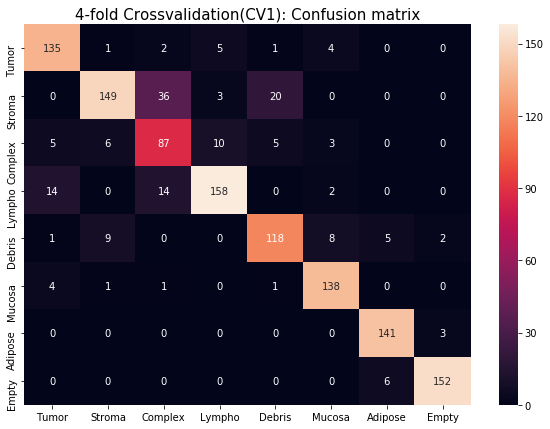

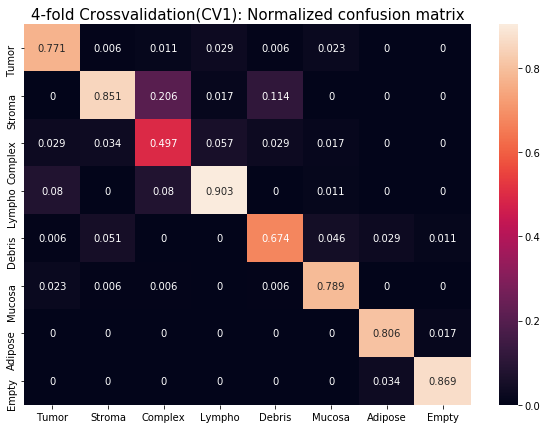

In [76]:
# First
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
label_list = ["Tumor", "Stroma", "Complex", "Lympho","Debris", "Mucosa","Adipose", "Empty"]
CV = 0
print("Accuracy: ", accuracy_rate_four_fold[CV])

# Confusion table without normalization
confusion = confusion_matrix(prediction_list_numpy_four_fold[CV], y_test_numpy_four_fold[CV])
df_cm = pd.DataFrame(confusion, index = [i for i in label_list],
                  columns = [i for i in label_list])
plt.figure(figsize = (10,7))
plt.title("4-fold Crossvalidation(CV"+str(CV+1)+"): Confusion matrix", size = 15)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt='g')
plt.show()

# Normalized confusion table 
confusion = (confusion_matrix(prediction_list_numpy_four_fold[CV], y_test_numpy_four_fold[CV])/175).round(3)
df_cm = pd.DataFrame(confusion, index = [i for i in label_list],
                  columns = [i for i in label_list])
plt.figure(figsize = (10,7))
plt.title("4-fold Crossvalidation(CV"+str(CV+1)+"): Normalized confusion matrix", size = 15)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt='g')
plt.show()

Accuracy:  0.892


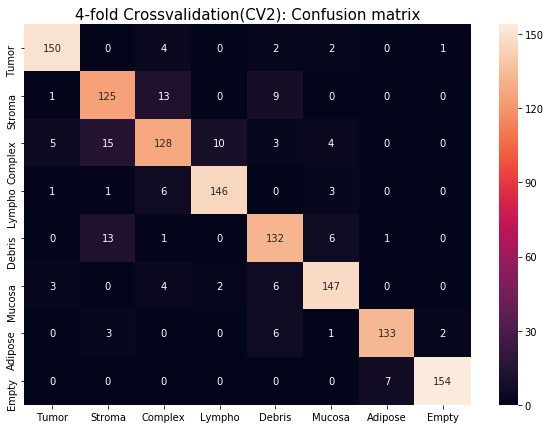

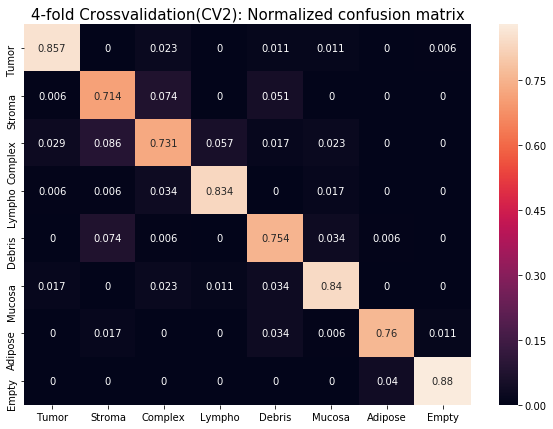

In [77]:
# Second
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
label_list = ["Tumor", "Stroma", "Complex", "Lympho","Debris", "Mucosa","Adipose", "Empty"]
CV = 1
print("Accuracy: ", accuracy_rate_four_fold[CV])

# Confusion table without normalization
confusion = confusion_matrix(prediction_list_numpy_four_fold[CV], y_test_numpy_four_fold[CV])
df_cm = pd.DataFrame(confusion, index = [i for i in label_list],
                  columns = [i for i in label_list])
plt.figure(figsize = (10,7))
plt.title("4-fold Crossvalidation(CV"+str(CV+1)+"): Confusion matrix", size = 15)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt='g')
plt.show()

# Normalized confusion table 
confusion = (confusion_matrix(prediction_list_numpy_four_fold[CV], y_test_numpy_four_fold[CV])/175).round(3)
df_cm = pd.DataFrame(confusion, index = [i for i in label_list],
                  columns = [i for i in label_list])
plt.figure(figsize = (10,7))
plt.title("4-fold Crossvalidation(CV"+str(CV+1)+"): Normalized confusion matrix", size = 15)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt='g')
plt.show()

Accuracy:  0.8408


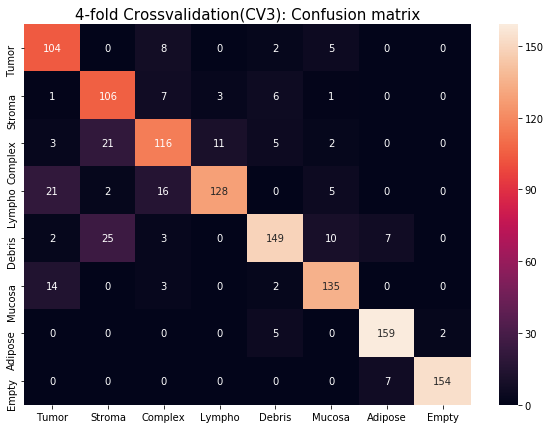

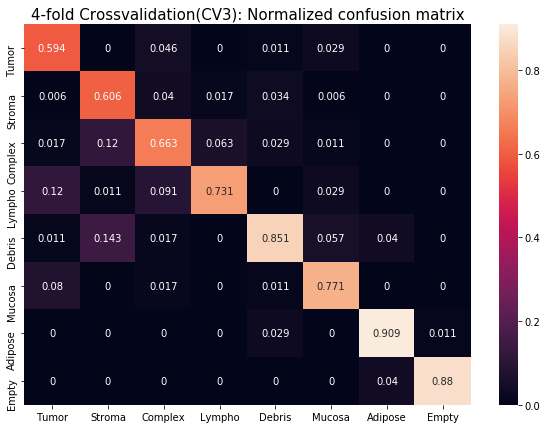

In [79]:
# Third
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
label_list = ["Tumor", "Stroma", "Complex", "Lympho","Debris", "Mucosa","Adipose", "Empty"]
CV = 2
print("Accuracy: ", accuracy_rate_four_fold[CV])

# Confusion table without normalization
confusion = confusion_matrix(prediction_list_numpy_four_fold[CV], y_test_numpy_four_fold[CV])
df_cm = pd.DataFrame(confusion, index = [i for i in label_list],
                  columns = [i for i in label_list])
plt.figure(figsize = (10,7))
plt.title("4-fold Crossvalidation(CV"+str(CV+1)+"): Confusion matrix", size = 15)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt='g')
plt.show()

# Normalized confusion table 
confusion = (confusion_matrix(prediction_list_numpy_four_fold[CV], y_test_numpy_four_fold[CV])/175).round(3)
df_cm = pd.DataFrame(confusion, index = [i for i in label_list],
                  columns = [i for i in label_list])
plt.figure(figsize = (10,7))
plt.title("4-fold Crossvalidation(CV"+str(CV+1)+"): Normalized confusion matrix", size = 15)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt='g')
plt.show()

Accuracy:  0.8472


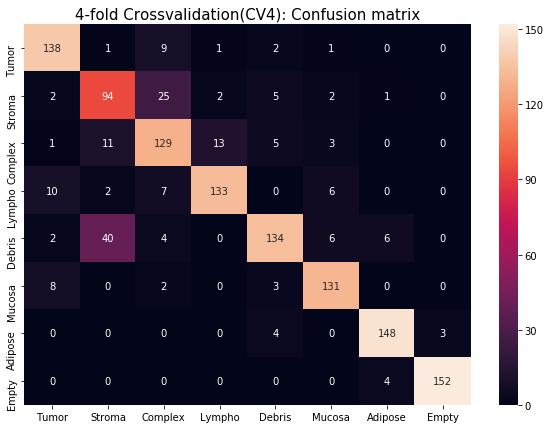

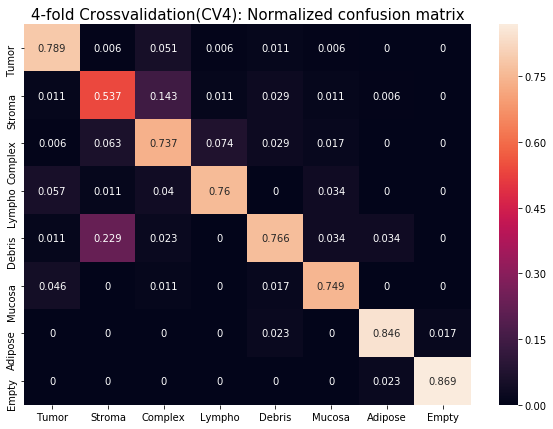

In [80]:
# Fourth
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
label_list = ["Tumor", "Stroma", "Complex", "Lympho","Debris", "Mucosa","Adipose", "Empty"]
CV = 3
print("Accuracy: ", accuracy_rate_four_fold[CV])

# Confusion table without normalization
confusion = confusion_matrix(prediction_list_numpy_four_fold[CV], y_test_numpy_four_fold[CV])
df_cm = pd.DataFrame(confusion, index = [i for i in label_list],
                  columns = [i for i in label_list])
plt.figure(figsize = (10,7))
plt.title("4-fold Crossvalidation(CV"+str(CV+1)+"): Confusion matrix", size = 15)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt='g')
plt.show()

# Normalized confusion table 
confusion = (confusion_matrix(prediction_list_numpy_four_fold[CV], y_test_numpy_four_fold[CV])/175).round(3)
df_cm = pd.DataFrame(confusion, index = [i for i in label_list],
                  columns = [i for i in label_list])
plt.figure(figsize = (10,7))
plt.title("4-fold Crossvalidation(CV"+str(CV+1)+"): Normalized confusion matrix", size = 15)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt='g')
plt.show()

# Visualization API

In [12]:
file_path = file_main_path + "Kather_texture_2016_larger_images_10/Kather_texture_2016_larger_images_10/CRC-Prim-HE-04_APPLICATION.tif"
histo_image = plt.imread(file_path)

resnet = resnet34()
resnet.load_state_dict(torch.load("HISTO_MODEL_RESNET34_ver12_rescale_four_fold3.pkl"))

# cut images and prediction
net_input_pixel = 150
stride = 30 # could be revised to improve resolution

x_part = (histo_image.shape[0] - net_input_pixel) // stride
x_space = ((histo_image.shape[0] - net_input_pixel) - stride * (x_part - 1)) // 2
y_part = (histo_image.shape[1] - net_input_pixel) // stride
y_space = ((histo_image.shape[1] - net_input_pixel) - stride * (y_part - 1)) // 2
total = int(x_part * y_part)
count = 1

histo_matrix_label = []
for i in range(x_part):
    #histo_ori_matrix_x = []
    #histo_matrix_x = []
    histo_matrix_x_label = []
    for j in range(y_part):
        x_start = int(i * stride + x_space)
        x_end = int(x_start + net_input_pixel)
        y_start = int(j * stride + y_space)
        y_end = int(y_start + net_input_pixel)
        
        histo_sub = histo_image[x_start:x_end,y_start:y_end,:]
        #histo_ori_matrix_x.append(histo_sub)

        histo_sub = histo_sub[np.newaxis,:,:,:]
        histo_sub = np.moveaxis(histo_sub, -1, 1)

        histo_sub_normal = scale(histo_sub, -1, 1)
        train_torch = torch.from_numpy(histo_sub_normal).float()

        prediction = resnet(train_torch)
        prediction_final = torch.max(prediction, 1)[1].data.squeeze()

        #histo_matrix_x.append(histo_sub_normal.reshape(3,150,150))
        histo_matrix_x_label.append(prediction_final.numpy().item())

        processing = "Prediction..." + str(round(((count)/ total * 100),2)) + "% " +"\r"
        sys.stdout.write(processing)
        sys.stdout.flush()
        count += 1

    #histo_ori_matrix.append(histo_ori_matrix_x)    
    #histo_matrix.append(histo_matrix_x)
    histo_matrix_label.append(histo_matrix_x_label)


In [13]:
histo_matrix_label = np.array(histo_matrix_label)

In [14]:
histo_matrix_label.shape

(161, 161)

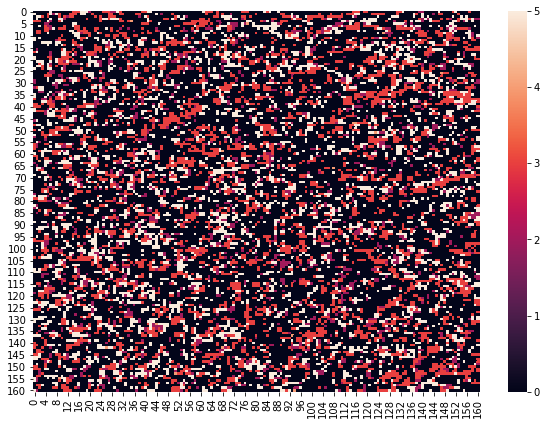

In [15]:
import seaborn as sns
plt.figure(figsize = (10,7))
#plt.title("4-fold Crossvalidation(CV"+str(CV+1)+"): Normalized confusion matrix", size = 15)
sns.heatmap(histo_matrix_label, annot=False, annot_kws={"size": 10}, fmt='g')
plt.show()

In [19]:
import pickle
with open(file_main_path+'four fold/histo_matrix_label_04.pickle', 'wb') as handle:
    pickle.dump(histo_matrix_label, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
histo_matrix_label_f = histo_matrix_label.flatten()

In [28]:
print("Tumor: ", sum(histo_matrix_label_f == 0))
print("Stroma: ", sum(histo_matrix_label_f == 1))
print("Complex: ", sum(histo_matrix_label_f == 2))
print("Lympho: ", sum(histo_matrix_label_f == 3))
print("Debris: ", sum(histo_matrix_label_f == 4))
print("Mucosa: ", sum(histo_matrix_label_f == 5))
print("Adipose: ", sum(histo_matrix_label_f == 6))
print("Empty: ", sum(histo_matrix_label_f == 7))
print("Tumor/Stroma ratio = ", sum(histo_matrix_label_f == 0)/sum(histo_matrix_label_f == 1) )

Tumor:  16173
Stroma:  3
Complex:  1481
Lympho:  4329
Debris:  33
Mucosa:  3902
Adipose:  0
Empty:  0
Tumor/Stroma ratio =  5391.0
